In [1]:
import numpy as np
import copy
import torch
import itertools
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, Normal
from torch.optim.lr_scheduler import LambdaLR, ConstantLR, CyclicLR
from torch.autograd import Variable
from scipy.optimize import root_scalar, shgo
import networkx as nx
import os
from app.launcher_classic import torch_dist, get_multimodal, proba_plackett_luce, pairwise_matrix
from app.launcher_classic import plot_end_training as plot_end_training_classic
from app.launcher_classic import torch_dist as torch_dist_classic
from app.launcher_pairwise import torch_dist as torch_dist_pairwise
#from app.launcher_pairwise import plot_end_training as plot_end_training_pairwise

device = "cpu"
default_tensor_type = torch.FloatTensor

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2023-01-25 14:26:12,637 -- Device - INFO -- Device is cpu


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

# Functions to plot experiments

In [4]:
def get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix="", folder_path=None):
    if folder_path == None:
        folder_path = f"{os.getcwd()}/perf_robustness_profile/"+prefix
    filename = f"perf_robustness_dist={dist}_w={w}_delta={delta}_epochs={epochs}_dist_type_sym={dist_type_sym}_norm_L{norm_type}_ratio_{ratio_norm_}.pt"
    return folder_path+filename

In [5]:
def load_plot_exp(path, dist, torch_all_ranks, plot_training=False, type_="classic", n=4):
    dict_res = torch.load(path)
    training_dict = dict_res['training_dict']
    final_val_dict = dict_res['final_val_dict']
    epochs = int(path.split('epochs=')[1].split('_')[0])
    p_torch=final_val_dict['p_torch']
    print(f"PTORCh = {p_torch}")
    #print(f"\n\n\n IN LOAD PLOT EXP --> path = {path}")
    
    for i, threshold in enumerate(training_dict.keys()):
        qlist_ = training_dict[threshold]['qs_'][epochs-10000:]
        q1 = np.mean(qlist_, axis=0)
        q2 = training_dict[threshold]['mean_qs'][-1]
        p_torch=final_val_dict['p_torch']
    
    if plot_training:
        for threshold in list(training_dict.keys()):
            if type_ == "classic":
                dist_Tp_Tq = lambda _p,_q: torch_dist_classic(dist, _p, _q, torch_all_ranks, threshold=threshold, dist_type_sym=dist_type_sym)
            elif type_ == "pairwise":
                dist_Tp_Tq = lambda _P,_Q: torch_dist_pairwise(dist, _P, _Q, torch_all_ranks, threshold=threshold, dist_type_sym=dist_type_sym)
            
            norms_ = training_dict[threshold]['norms']
            losses = training_dict[threshold]['losses']
            mean_qs_=training_dict[threshold]['mean_qs']
            #check_qs = mean_qs_[-2:]
            #Qs = [pairwise_matrix(check_qs_, torch_all_ranks, n=n) for check_qs_ in check_qs]
            #print(f"Distrib adv = {check_qs}\nPairwise adv = {Qs}")
            phis_=training_dict[threshold]['phis']
            mean_phi2_=training_dict[threshold]['mean_phi2']
            lambdas_=training_dict[threshold]['lambdas']
            mean_lambdas_=training_dict[threshold]['mean_lambdas']
            grad_data=training_dict[threshold]['grad_data']
            freq_phi_=training_dict[threshold]['freq_phi']
            p_torch=final_val_dict['p_torch']
            print(f"load plot n = {n}, ptorch = {p_torch.shape}, all ranks = {torch_all_ranks.shape}")
            P=pairwise_matrix(p_torch, torch_all_ranks, n=n)
            
            if type_ == "classic":
                plot_end_training_classic(p_torch=p_torch, dist_Tp_Tq=dist_Tp_Tq, norms_=norms_, losses=losses, mean_qs_=mean_qs_, phis_=phis_, mean_phi2_=mean_phi2_, lambdas_=lambdas_, mean_lambdas_=mean_lambdas_, grad_data=grad_data, freq_phi_=freq_phi_, norm_type=norm_type)
            elif type_ == "pairwise":
                plot_end_training_pairwise(P=P, dist_Tp_Tq=dist_Tp_Tq, norms_=norms_, losses=losses, mean_qs_=mean_qs_, phis_=phis_, mean_phi2_=mean_phi2_, lambdas_=lambdas_, mean_lambdas_=mean_lambdas_, grad_data=grad_data, freq_phi_=freq_phi_, norm_type=norm_type)

    return final_val_dict["perf_list"], final_val_dict["eps_list1"], final_val_dict["eps_list2"], final_val_dict["alt_eps_list1"], final_val_dict["alt_eps_list2"], final_val_dict["thresholds"]


In [6]:
def get_res(mypath, dist, torch_all_ranks, plot_training=False, type_="classic", n=4, choose_val="full"):
    
    perf_list, eps_list1, eps_list2, alt_eps_list1, alt_eps_list2, thresholds = load_plot_exp(mypath, dist, torch_all_ranks, plot_training=plot_training, type_=type_, n=n)
    
    print(f"perf_list = {perf_list} \n\n eps_list1 (l1 norm) = {eps_list1}  \n eps_list2 (l2 norm) = {eps_list2} \n\n alt_eps_list1 (l1 norm) = {alt_eps_list1}  \n alt_eps_list2 (l2 norm) = {alt_eps_list2} \n\n")
    
    l1_norm = list()
    for i in range(len(eps_list1)):
        minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) ) 
        maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) ) 
        if choose_val == "full":
            l1_norm.append(torch.tensor(eps_list1[i]))
        elif choose_val == "alt":
            l1_norm.append(torch.tensor(alt_eps_list1[i]))
        elif choose_val == "min":
            l1_norm.append(minval)
        elif choose_val == "max":
            l1_norm.append(maxval)

    l2_norm = list()
    for i in range(len(eps_list2)):
        minval = torch.min( torch.tensor(eps_list2[i]), torch.tensor(alt_eps_list2[i]) ) 
        maxval = torch.max( torch.tensor(eps_list2[i]), torch.tensor(alt_eps_list2[i]) ) 
        if choose_val == "full":
            l2_norm.append(torch.tensor(eps_list2[i]))
        elif choose_val == "alt":
            l2_norm.append(torch.tensor(alt_eps_list2[i]))
        elif choose_val == "min":
            l2_norm.append(minval)
        elif choose_val == "max":
            l2_norm.append(maxval)

    #print(f"final res l1 norm = {l1_norm} \nfinal res l2 norm = {l2_norm} ")
    
    return perf_list, l1_norm, l2_norm
    
    

In [155]:
def exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add="", plot_training=False, type_="classic", n=4, thresholds=np.linspace(0,0.5,11), choose_val="full"):
    fig_size = (7, 3)
    plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
        })
    f = plt.figure(figsize=fig_size)
    axarr = f.add_subplot(1,1,1)
    min_cmap = thresholds[0]
    max_cmap = thresholds[-1]
    for i, (my_path, dist) in enumerate(zip(my_paths, dists)):
        perf_list, l1_norm, l2_norm = get_res(my_path, dist, torch_all_ranks, plot_training=plot_training, type_=type_, n=n, choose_val=choose_val)
        t = thresholds
        l1_norm = [1/2*l1_norm_ for l1_norm_ in l1_norm]
        perf_list = [perf_list_/(n*(n-1)/2) for perf_list_ in perf_list]
        print(f"normalize l1 norm = {l1_norm}")
        if dist == "erm":
            markertype = "x"
            lab = "Median"
        elif dist == "maxpair":
            #l1_norm = l1_norm[:-1]
            #perf_list = perf_list[:-1]
            markertype = "o"
            cm = plt.cm.get_cmap('Reds')
            lab = "Maxpair"
        elif dist == "merge":
            #l1_norm = l1_norm[:-1]
            #perf_list = perf_list[:-1]
            markertype = "^"
            cm = plt.cm.get_cmap('Reds')
            lab = "Merge"
        print(f"for point nb {i} --> l1_norm = {l1_norm}")
        if norm=="L1":
            if dist != "erm":
                list_col = [cm((i+1)/len(thresholds)) for i in range(len(thresholds))]
                #plt.scatter(perf_list, l1_norm, marker=markertype, c=t, label=lab, vmin=min_cmap, vmax=max_cmap, cmap=cm, edgecolors="black", s=90)
                scatter1 = plt.scatter(perf_list, l1_norm, marker=markertype, c=list_col, edgecolors="black", s=90)
            else:
                scatter2 = plt.scatter(perf_list, l1_norm, marker=markertype, s=120, c="cornflowerblue")
        else:
            if dist != "erm":
                list_col = [cm((i+1)/len(thresholds)) for i in range(len(thresholds))]
                #plt.scatter(perf_list, l2_norm, marker=markertype, c=t, label=lab, vmax=max_cmap, cmap=cm, edgecolors="black", s=90)
                scatter1 = plt.scatter(perf_list, l2_norm, marker=markertype, c=list_col, label=lab, edgecolors="black", s=90)
            else:
                scatter2 = plt.scatter(perf_list, l2_norm, marker=markertype, label=lab, s=120, c="cornflowerblue")
    #plt.legend()
    print(f"scatter legend = {scatter1.legend_elements()[0]}, {scatter2.legend_elements()[0]}")
    plt.legend(handles=scatter1.legend_elements()[0], labels=thresholds)
    plt.xlabel(f"Loss", fontsize=12)
    plt.ylabel(r"Robustness - attack budget $\varepsilon^*(1)$", fontsize=12)
    plt.title(f"{title_add}", fontsize=14)
    #if ("maxpair" in dists):
    #    cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(min_cmap, max_cmap)),
    #             orientation='vertical', format='%.3f', label="Threshold")
    #elif ("merge" in dists):
    #    cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(min_cmap, max_cmap)),
    #             orientation='vertical', format='%.3f', label="Threshold", location='left')
    #for t in cbar.ax.get_yticklabels():
    #    t.set_fontsize(12)
    #cbar.set_label(label="Thresholds", size=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.ylim(3, 5)
    return f

In [126]:
def get_pair_results(my_paths, dists, torch_all_ranks, title_add="", plot_training=False, n=4, thresholds=np.linspace(0,0.5,11), choose_val="full"):
    
    perf_list_res = list()
    l1_norm_res = list()
    
    for i, (my_path, dist) in enumerate(zip(my_paths, dists)):
        print(f"path get pair = {my_path}")
        perf_list, l1_norm, l2_norm = get_res(my_path, dist, torch_all_ranks, plot_training=plot_training, type_="classic", n=n, choose_val=choose_val)
        print(f"res get paur ={perf_list}, {l1_norm}")
        perf_list_res.append(perf_list[0]/(n*(n-1)/2))
        l1_norm_res.append(l1_norm[0].item()/2)
    
    return perf_list_res, l1_norm_res
    
    
    
    

[<matplotlib.lines.Line2D object at 0x13547f400>, <matplotlib.lines.Line2D object at 0x13547f760>, <matplotlib.lines.Line2D object at 0x1354aac10>]


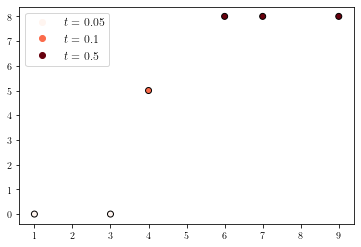

In [62]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

x = [1, 3, 4, 6, 7, 9]
y = [0, 0, 5, 8, 8, 8]
classes = [r'$t=0.05$', r'$t=0.1$', r'$t=0.5$']
classes2 = ["A", "B", "C"]
values = [1/3, 1/3, 2/3, 3/3, 3/3, 3/3]
cm = plt.cm.get_cmap('Reds')
list_col = [cm(1/3), cm(1/3), cm(2/3), cm(1), cm(1), cm(1)]
scatter = plt.scatter(x, y, c=values, cmap=cm, edgecolor="black")
plt.legend(handles=scatter.legend_elements()[0], labels=classes, fontsize=12)

print(scatter.legend_elements()[0])

# Plotting with launcher classic fixed

## Two untied

### Gap = 0.1

['/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/depth-functions/perf_robustness_profile/two_untied/perf_robustness_dist=erm_w=two_untied_mix=1.0_gap=0.1_seed=279_delta=1_epochs=10001_dist_type_sym=False_norm_L1_ratio_1.0.pt', '/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/depth-functions/perf_robustness_profile/two_untied/perf_robustness_dist=maxpair_w=two_untied_mix=1.0_gap=0.1_seed=279_delta=1_epochs=10001_dist_type_sym=False_norm_L1_ratio_1.0.pt']
PTORCh = tensor([[0.6000, 0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], dtype=torch.float64)
perf_list = [0.40000012516975403] 

 eps_list1 (l1 norm) = [tensor(0.4022, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.2066, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(0.2789, dtype=torch.float64)]  
 alt_eps_li

/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

PTORCh = tensor([[0.6000, 0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
perf_list = [0.40000012516975403, 0.5000001341104507, 3.0000000596046448] 

 eps_list1 (l1 norm) = [tensor(0.3029), tensor(0.9043), tensor(1.8606)]  
 eps_list2 (l2 norm) = [tensor(0.1533), tensor(0.3802), tensor(0.7015)] 

 alt_eps_list1 (l1 norm) = [tensor(0.1710), tensor(0.7656), tensor(1.8471)]  
 alt_eps_list2 (l2 norm) = [tensor(0.1710), tensor(0.7656), tensor(1.8471)] 


normalize l1 norm = [tensor(0.0855), tensor(0.3828), tensor(0.9236)]
for point nb 1 --> l1_norm = [tensor(0.0855), tensor(0.3828), tensor(0.9236)]
scatter legend = [], []


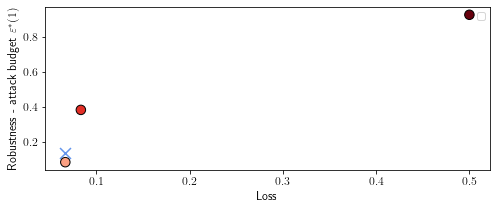

In [45]:
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

# Basic (mostly unchanged) parameters
delta = 1
epochs = 10001
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "two_untied/"

# Parameters changing for every exp
w = "two_untied_mix=1.0_gap=0.1_seed=279"
#title_add = r"Loss vs Robustness Tradeoff ($\delta = 1$)"
title_add = ""
thresholds = np.array([0.0500, 0.1010, 0.5000])
choose_val="alt"

# dist
dists = ["erm", "maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]
print(my_paths)

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="classic", n=4, thresholds=thresholds, choose_val=choose_val)
plt.tight_layout()
#plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/classic_unimodal_n=4_seed=938.png", dpi=200)



### Gap = 0.01

['/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/depth-functions/perf_robustness_profile/two_untied/perf_robustness_dist=erm_w=two_untied_mix=0.95_gap=0.01_seed=279_delta=1_epochs=10001_dist_type_sym=False_norm_L1_ratio_1.0.pt', '/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/depth-functions/perf_robustness_profile/two_untied/perf_robustness_dist=maxpair_w=two_untied_mix=0.95_gap=0.01_seed=279_delta=1_epochs=10001_dist_type_sym=False_norm_L1_ratio_1.0.pt', '/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/depth-functions/perf_robustness_profile/two_untied/perf_robustness_dist=merge_w=two_untied_mix=0.95_gap=0.01_seed=279_delta=1_epochs=10001_dist_type_sym=False_norm_L1_ratio_1.0.pt']
PTORCh = tensor([[4.8710e-01, 4.6834e-01, 2.5084e-03, 1.9022e-03, 2.4497e-04, 4.1282e-04,
         1.1550e-03, 3.1756e-03, 3.8283e-03, 3.9353e-03, 3.6042e-03, 3.3915e-03,
         2.2852e-03, 1.4876e-03, 1.9613e-03, 6.8242e-04, 1.4

/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

PTORCh = tensor([[4.8710e-01, 4.6834e-01, 2.5084e-03, 1.9022e-03, 2.4497e-04, 4.1282e-04,
         1.1550e-03, 3.1756e-03, 3.8283e-03, 3.9353e-03, 3.6042e-03, 3.3915e-03,
         2.2852e-03, 1.4876e-03, 1.9613e-03, 6.8242e-04, 1.4853e-04, 2.5638e-03,
         1.7132e-03, 7.7790e-04, 1.8581e-03, 7.9835e-04, 3.2958e-03, 2.8358e-03]])
perf_list = [0.6119546290719882, 0.6215095614825259, 3.0000000423024176] 

 eps_list1 (l1 norm) = [tensor(0.2423), tensor(0.9686), tensor(1.7715)]  
 eps_list2 (l2 norm) = [tensor(0.0979), tensor(0.4212), tensor(0.6543)] 

 alt_eps_list1 (l1 norm) = [tensor(0.0671), tensor(0.8614), tensor(1.7580)]  
 alt_eps_list2 (l2 norm) = [tensor(0.0671), tensor(0.8614), tensor(1.7580)] 


normalize l1 norm = [tensor(0.0335), tensor(0.4307), tensor(0.8790)]
for point nb 1 --> l1_norm = [tensor(0.0335), tensor(0.4307), tensor(0.8790)]
PTORCh = tensor([[4.8710e-01, 4.6834e-01, 2.5084e-03, 1.9022e-03, 2.4497e-04, 4.1282e-04,
         1.1550e-03, 3.1756e-03, 3.8283e-03, 3.9

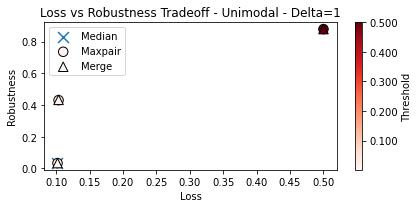

In [9]:
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

# Basic (mostly unchanged) parameters
delta = 1
epochs = 10001
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "two_untied/"

# Parameters changing for every exp
w = "two_untied_mix=0.95_gap=0.01_seed=279"
title_add = "Loss vs Robustness Tradeoff - Unimodal - Delta=1"
#thresholds = np.array([0.0500, 0.1010, 0.5000])
thresholds = np.array([0.001, 0.0101, 0.5])
choose_val="alt"

# dist
dists = ["erm", "maxpair", "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]
print(my_paths)

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="classic", n=4, thresholds=thresholds, choose_val=choose_val)
plt.tight_layout()
#plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/classic_unimodal_n=4_seed=938.png", dpi=200)


### Multimodal

['/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/depth-functions/perf_robustness_profile/multimodal_sst/perf_robustness_dist=erm_w=multimodal_sst_m=1.0_seed=279_n=4_delta=1_epochs=10001_dist_type_sym=False_norm_L1_ratio_1.0.pt', '/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/depth-functions/perf_robustness_profile/multimodal_sst/perf_robustness_dist=maxpair_w=multimodal_sst_m=1.0_seed=279_n=4_delta=1_epochs=10001_dist_type_sym=False_norm_L1_ratio_1.0.pt']
PTORCh = tensor([[0.1219, 0.1026, 0.0595, 0.0398, 0.0477, 0.0351, 0.0284, 0.0251, 0.0179,
         0.0307, 0.0173, 0.0329, 0.0290, 0.0408, 0.0225, 0.0367, 0.0490, 0.0501,
         0.0227, 0.0328, 0.0208, 0.0400, 0.0457, 0.0509]])
perf_list = [2.6904711816459894] 

 eps_list1 (l1 norm) = [tensor(0.0102)]  
 eps_list2 (l2 norm) = [tensor(0.0039)] 

 alt_eps_list1 (l1 norm) = [tensor(0.0002)]  
 alt_eps_list2 (l2 norm) = [tensor(0.0002)] 


normalize l1 norm = [tensor(9.5382e-05)]
for 

/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

PTORCh = tensor([[0.1219, 0.1026, 0.0595, 0.0398, 0.0477, 0.0351, 0.0284, 0.0251, 0.0179,
         0.0307, 0.0173, 0.0329, 0.0290, 0.0408, 0.0225, 0.0367, 0.0490, 0.0501,
         0.0227, 0.0328, 0.0208, 0.0400, 0.0457, 0.0509]])
perf_list = [2.698580304160714, 2.7493435703217983, 2.8789789397269487, 2.999999977648258, 2.999999977648258, 2.999999977648258] 

 eps_list1 (l1 norm) = [tensor(0.0102), tensor(0.0102), tensor(0.0102), tensor(0.3368), tensor(0.3368), tensor(0.3368)]  
 eps_list2 (l2 norm) = [tensor(0.0039), tensor(0.0039), tensor(0.0039), tensor(0.1099), tensor(0.1099), tensor(0.1099)] 

 alt_eps_list1 (l1 norm) = [tensor(6.1797e-05), tensor(0.0001), tensor(5.4307e-05), tensor(0.3511), tensor(0.3511), tensor(0.3511)]  
 alt_eps_list2 (l2 norm) = [tensor(6.1797e-05), tensor(0.0001), tensor(5.4307e-05), tensor(0.3511), tensor(0.3511), tensor(0.3511)] 


normalize l1 norm = [tensor(3.0898e-05), tensor(7.1406e-05), tensor(2.7154e-05), tensor(0.1756), tensor(0.1756), tensor(0.1756

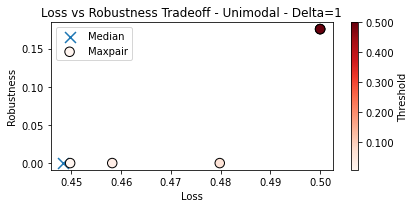

In [11]:
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

# Basic (mostly unchanged) parameters
delta = 1
epochs = 10001
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "multimodal_sst/"

# Parameters changing for every exp
w = "multimodal_sst_m=1.0_seed=279_n=4"
title_add = "Loss vs Robustness Tradeoff - Unimodal - Delta=1"
thresholds = np.array([0.009, 0.03, 0.06, 0.075, 0.13, 0.5])
choose_val="alt"

# dist
dists = ["erm", "maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]
print(my_paths)

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="classic", n=4, thresholds=thresholds, choose_val=choose_val)
plt.tight_layout()
#plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/classic_unimodal_n=4_seed=938.png", dpi=200)


### Peaked

PTORCh = tensor([[9.6459e-01, 3.4842e-02, 9.0614e-06, 2.9676e-12, 3.2731e-07, 2.9676e-12,
         5.4236e-04, 1.9591e-05, 2.8648e-12, 5.2753e-22, 1.0348e-13, 5.2753e-22,
         5.0922e-09, 1.6677e-15, 2.8632e-12, 5.2724e-22, 9.3716e-19, 5.2694e-22,
         1.8394e-10, 1.6677e-15, 1.0342e-13, 5.2724e-22, 9.3716e-19, 5.2694e-22]],
       dtype=torch.float64)
perf_list = [0.03543361728953287] 

 eps_list1 (l1 norm) = [tensor(1.9251, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.9967, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(1.9291, dtype=torch.float64)]  
 alt_eps_list2 (l2 norm) = [tensor(1.9291, dtype=torch.float64)] 


normalize l1 norm = [tensor(0.9625, dtype=torch.float64)]
for point nb 0 --> l1_norm = [tensor(0.9625, dtype=torch.float64)]


/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

PTORCh = tensor([[9.6459e-01, 3.4842e-02, 9.0614e-06, 2.9676e-12, 3.2731e-07, 2.9676e-12,
         5.4236e-04, 1.9591e-05, 2.8648e-12, 5.2753e-22, 1.0348e-13, 5.2753e-22,
         5.0922e-09, 1.6677e-15, 2.8632e-12, 5.2724e-22, 9.3716e-19, 5.2694e-22,
         1.8394e-10, 1.6677e-15, 1.0342e-13, 5.2724e-22, 9.3716e-19, 5.2694e-22]],
       dtype=torch.float64)
perf_list = [0.03543361728953287, 0.5005713541582666, 0.5005713541582666, 2.999999999999999] 

 eps_list1 (l1 norm) = [tensor(1.1944, dtype=torch.float64), tensor(0.1981, dtype=torch.float64), tensor(0.1795, dtype=torch.float64), tensor(1.9286, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.6359, dtype=torch.float64), tensor(0.0874, dtype=torch.float64), tensor(0.0918, dtype=torch.float64), tensor(0.9856, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(1.0144, dtype=torch.float64), tensor(0.0487, dtype=torch.float64), tensor(0.0173, dtype=torch.float64), tensor(1.9291, dtype=torch.float64)]  
 alt_eps_list2 (

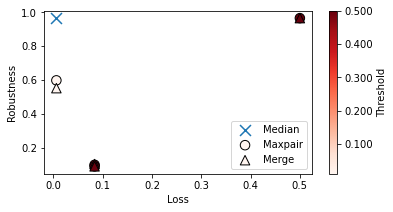

In [12]:
# Basic (mostly unchanged) parameters
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

delta = 1
epochs = 10001
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "unimodal/"
seed_val = 279
choose_val = "full"

# Parameters changing for every exp seed = 279
m = 10
w = "[2.2831823e-01 1.2837668e-04 1.1639423e-09 4.2043390e-11]"
title_add = ""

thresholds = np.array([0.01, 0.47, 0.495, 0.5])

# dist
dists = ["erm", "maxpair", "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="classic", n=n_items, thresholds=thresholds, choose_val=choose_val)
#plt.tight_layout()
#plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/classic_dirac_n=4_seed=279.png", dpi=200)


  

## Uniform

PTORCh = tensor([[0.0426, 0.0425, 0.0424, 0.0417, 0.0422, 0.0417, 0.0425, 0.0424, 0.0421,
         0.0412, 0.0419, 0.0411, 0.0421, 0.0415, 0.0419, 0.0410, 0.0410, 0.0407,
         0.0419, 0.0414, 0.0417, 0.0409, 0.0410, 0.0407]], dtype=torch.float64)
perf_list = [2.9802862798290857] 

 eps_list1 (l1 norm) = [tensor(0.0014, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.0003, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(0.0011, dtype=torch.float64)]  
 alt_eps_list2 (l2 norm) = [tensor(0.0011, dtype=torch.float64)] 


normalize l1 norm = [tensor(0.0007, dtype=torch.float64)]
for point nb 0 --> l1_norm = [tensor(0.0007, dtype=torch.float64)]


/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

PTORCh = tensor([[0.0426, 0.0425, 0.0424, 0.0417, 0.0422, 0.0417, 0.0425, 0.0424, 0.0421,
         0.0412, 0.0419, 0.0411, 0.0421, 0.0415, 0.0419, 0.0410, 0.0410, 0.0407,
         0.0419, 0.0414, 0.0417, 0.0409, 0.0410, 0.0407]], dtype=torch.float64)
perf_list = [2.9802862798290857, 2.981116496611806, 3.0] 

 eps_list1 (l1 norm) = [tensor(0.0011, dtype=torch.float64), tensor(0.0006, dtype=torch.float64), tensor(0.0074, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.0003, dtype=torch.float64), tensor(0.0002, dtype=torch.float64), tensor(0.0016, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(0.0013, dtype=torch.float64), tensor(0.0008, dtype=torch.float64), tensor(0.0064, dtype=torch.float64)]  
 alt_eps_list2 (l2 norm) = [tensor(0.0013, dtype=torch.float64), tensor(0.0008, dtype=torch.float64), tensor(0.0064, dtype=torch.float64)] 


normalize l1 norm = [tensor(0.0006, dtype=torch.float64), tensor(0.0003, dtype=torch.float64), tensor(0.0037, dtype=torch.float64)]
f

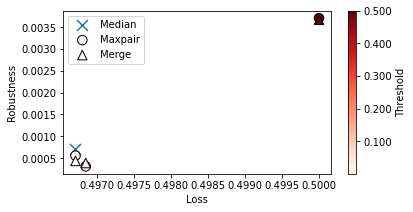

In [13]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 10001
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "unimodal/"
seed_val = 279
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

choose_val = "full"

# Parameters changing for every exp seed = 279
m = 0.01
w = f"[0.99852407 0.9910795  0.9796387  0.97639084]"
title_add = ""

thresholds = np.array([2.0000e-04, 1.0000e-03, 5.0000e-01])

# dist
dists = ["erm", "maxpair", "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="classic", n=n_items, thresholds=thresholds, choose_val=choose_val)
#plt.tight_layout()
#plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/classic_uniform_n=4_seed=279.png", dpi=200)

                      

# Random Plackett Luce

PTORCh = tensor([[0.1088, 0.0678, 0.0781, 0.0298, 0.0418, 0.0255, 0.1045, 0.0652, 0.0709,
         0.0250, 0.0382, 0.0216, 0.0632, 0.0241, 0.0597, 0.0210, 0.0160, 0.0148,
         0.0309, 0.0189, 0.0294, 0.0166, 0.0146, 0.0135]], dtype=torch.float64)
perf_list = [2.1413761003903655] 

 eps_list1 (l1 norm) = [tensor(0.0255, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.0055, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(0.0281, dtype=torch.float64)]  
 alt_eps_list2 (l2 norm) = [tensor(0.0281, dtype=torch.float64)] 


PTORCh = tensor([[0.1088, 0.0678, 0.0781, 0.0298, 0.0418, 0.0255, 0.1045, 0.0652, 0.0709,
         0.0250, 0.0382, 0.0216, 0.0632, 0.0241, 0.0597, 0.0210, 0.0160, 0.0148,
         0.0309, 0.0189, 0.0294, 0.0166, 0.0146, 0.0135]], dtype=torch.float64)
perf_list = [2.1608390305320806] 

 eps_list1 (l1 norm) = [tensor(0.2816, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.0722, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(0.2518

/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

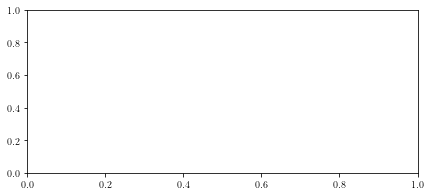

In [90]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 20001
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "unimodal/"
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

choose_val = "full"

# Parameters changing for every exp seed = 279
w = f"[1.1173979 1.0336659 0.6316072 0.3937561]"
title_add = ""

thresholds = np.array([0.05])

# dist
dists = ["erm", "maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]
perf_18, tv_dist_18 = get_pair_results(my_paths, dists, torch_all_ranks, title_add="", plot_training=False, n=4, thresholds=np.linspace(0,0.5,11), choose_val="full")

                      

PTORCh = tensor([[0.2650, 0.2534, 0.0685, 0.0099, 0.0651, 0.0098, 0.1166, 0.1114, 0.0123,
         0.0007, 0.0118, 0.0007, 0.0234, 0.0034, 0.0096, 0.0005, 0.0011, 0.0004,
         0.0222, 0.0034, 0.0091, 0.0005, 0.0011, 0.0004]], dtype=torch.float64)
perf_list = [1.1258836323997201] 

 eps_list1 (l1 norm) = [tensor(0.0132, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.0040, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(0.0127, dtype=torch.float64)]  
 alt_eps_list2 (l2 norm) = [tensor(0.0127, dtype=torch.float64)] 


PTORCh = tensor([[0.2650, 0.2534, 0.0685, 0.0099, 0.0651, 0.0098, 0.1166, 0.1114, 0.0123,
         0.0007, 0.0118, 0.0007, 0.0234, 0.0034, 0.0096, 0.0005, 0.0011, 0.0004,
         0.0222, 0.0034, 0.0091, 0.0005, 0.0011, 0.0004]], dtype=torch.float64)
perf_list = [1.137143160998768] 

 eps_list1 (l1 norm) = [tensor(0.4656, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.1706, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(0.3655,

/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

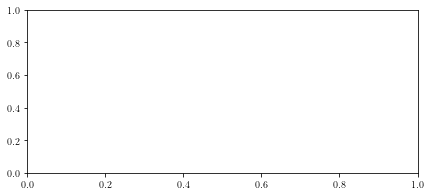

In [91]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 20001
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "unimodal/"
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

choose_val = "full"

# Parameters changing for every exp seed = 279
w = f"[1.7226691  0.6500638  0.09824223 0.09391503]"
title_add = ""

thresholds = np.array([0.05])

# dist
dists = ["erm", "maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]
perf_283, tv_dist_283 = get_pair_results(my_paths, dists, torch_all_ranks, title_add="", plot_training=False, n=4, thresholds=np.linspace(0,0.5,11), choose_val="full")
print(perf_283, tv_dist_283)


PTORCh = tensor([[0.1650, 0.0666, 0.1519, 0.0547, 0.0441, 0.0393, 0.1002, 0.0405, 0.0445,
         0.0065, 0.0151, 0.0055, 0.0896, 0.0323, 0.0433, 0.0063, 0.0127, 0.0052,
         0.0228, 0.0204, 0.0129, 0.0047, 0.0112, 0.0045]], dtype=torch.float64)
perf_list = [1.7076694239642527] 

 eps_list1 (l1 norm) = [tensor(0.0847, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.0251, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(0.0543, dtype=torch.float64)]  
 alt_eps_list2 (l2 norm) = [tensor(0.0543, dtype=torch.float64)] 


PTORCh = tensor([[0.1650, 0.0666, 0.1519, 0.0547, 0.0441, 0.0393, 0.1002, 0.0405, 0.0445,
         0.0065, 0.0151, 0.0055, 0.0896, 0.0323, 0.0433, 0.0063, 0.0127, 0.0052,
         0.0228, 0.0204, 0.0129, 0.0047, 0.0112, 0.0045]], dtype=torch.float64)
perf_list = [1.7362260592552405] 

 eps_list1 (l1 norm) = [tensor(0.4847, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.1338, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(0.4333

/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

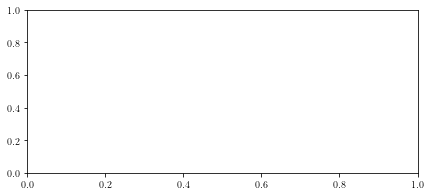

In [93]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 20001
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "unimodal/"
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

choose_val = "full"

# Parameters changing for every exp seed = 279
w = f"[2.7095466  1.1030647  0.98387283 0.3974442 ]"
title_add = ""

thresholds = np.array([0.05])

# dist
dists = ["erm", "maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]
perf_1903, tv_dist_1903 = get_pair_results(my_paths, dists, torch_all_ranks, title_add="", plot_training=False, n=4, thresholds=np.linspace(0,0.5,11), choose_val="full")
print(perf_1903, tv_dist_1903)


PTORCh = tensor([[4.8710e-01, 4.6834e-01, 2.5084e-03, 1.9022e-03, 2.4497e-04, 4.1282e-04,
         1.1550e-03, 3.1756e-03, 3.8283e-03, 3.9353e-03, 3.6042e-03, 3.3915e-03,
         2.2852e-03, 1.4876e-03, 1.9613e-03, 6.8242e-04, 1.4853e-04, 2.5638e-03,
         1.7132e-03, 7.7790e-04, 1.8581e-03, 7.9835e-04, 3.2958e-03, 2.8358e-03]])
perf_list = [0.6119546290719882] 

 eps_list1 (l1 norm) = [tensor(0.0114)]  
 eps_list2 (l2 norm) = [tensor(0.0059)] 

 alt_eps_list1 (l1 norm) = [tensor(0.0067)]  
 alt_eps_list2 (l2 norm) = [tensor(0.0067)] 


PTORCh = tensor([[4.8710e-01, 4.6834e-01, 2.5084e-03, 1.9022e-03, 2.4497e-04, 4.1282e-04,
         1.1550e-03, 3.1756e-03, 3.8283e-03, 3.9353e-03, 3.6042e-03, 3.3915e-03,
         2.2852e-03, 1.4876e-03, 1.9613e-03, 6.8242e-04, 1.4853e-04, 2.5638e-03,
         1.7132e-03, 7.7790e-04, 1.8581e-03, 7.9835e-04, 3.2958e-03, 2.8358e-03]])
perf_list = [0.6215095614825259] 

 eps_list1 (l1 norm) = [tensor(0.9837)]  
 eps_list2 (l2 norm) = [tensor(0.3931)] 


/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

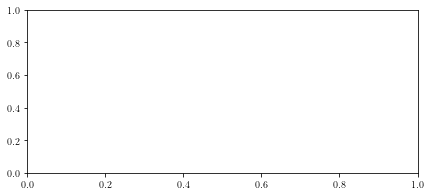

In [95]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 20001
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "two_untied/"
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

choose_val = "full"

# Parameters changing for every exp
w = "two_untied_mix=0.95_gap=0.01_seed=279"
title_add = ""
thresholds = np.array([0.5])

# dist
dists = ["erm", "maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]
perf_bucket_001, tv_dist_bucket_001 = get_pair_results(my_paths, dists, torch_all_ranks, title_add="", plot_training=False, n=4, thresholds=thresholds, choose_val="full")
print(perf_bucket_001, tv_dist_bucket_001)



PTORCh = tensor([[0.6000, 0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
perf_list = [0.40000012516975403] 

 eps_list1 (l1 norm) = [tensor(0.2258)]  
 eps_list2 (l2 norm) = [tensor(0.1557)] 

 alt_eps_list1 (l1 norm) = [tensor(0.2002)]  
 alt_eps_list2 (l2 norm) = [tensor(0.2002)] 


PTORCh = tensor([[0.6000, 0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
perf_list = [0.40000012516975403] 

 eps_list1 (l1 norm) = [tensor(0.7901)]  
 eps_list2 (l2 norm) = [tensor(0.3243)] 

 alt_eps_list1 (l1 norm) = [tensor(0.8182)]  
 alt_eps_list2 (l2 norm) = [tensor(0.8182)] 


[0.06666668752829234, 0.06666668752829234] [0.1128893792629242, 0.3950396776199341]


/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

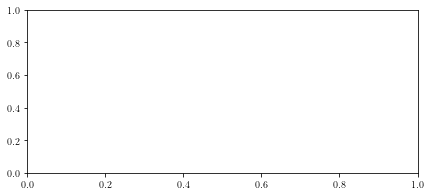

In [109]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 20001
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "two_untied/"
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

choose_val = "full"

# Parameters changing for every exp
w = "two_untied_mix=1_gap=0.1_seed=279"
title_add = ""
thresholds = np.array([0.5])

# dist
dists = ["erm", "maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]
perf_bucket_01, tv_dist_bucket_01 = get_pair_results(my_paths, dists, torch_all_ranks, title_add="", plot_training=False, n=4, thresholds=thresholds, choose_val="full")
print(perf_bucket_01, tv_dist_bucket_01)



In [127]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 20001
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "unimodal/"
seed_val = 279
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

choose_val = "full"

# Parameters changing for every exp seed = 279
m = 0.01
w = f"[0.99852407 0.9910795  0.9796387  0.97639084]"
title_add = ""

thresholds = np.array([0.05])

# dist
dists = ["erm", "maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]
perf_uniform, tv_dist_uniform = get_pair_results(my_paths, dists, torch_all_ranks, title_add="", plot_training=False, n=4, thresholds=thresholds, choose_val="full")
print(perf_uniform, tv_dist_uniform)



path get pair = /Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/depth-functions/perf_robustness_profile/unimodal/perf_robustness_dist=erm_w=[0.99852407 0.9910795  0.9796387  0.97639084]_delta=1_epochs=20001_dist_type_sym=False_norm_L1_ratio_1.0.pt
PTORCh = tensor([[0.0426, 0.0425, 0.0424, 0.0417, 0.0422, 0.0417, 0.0425, 0.0424, 0.0421,
         0.0412, 0.0419, 0.0411, 0.0421, 0.0415, 0.0419, 0.0410, 0.0410, 0.0407,
         0.0419, 0.0414, 0.0417, 0.0409, 0.0410, 0.0407]], dtype=torch.float64)
perf_list = [2.9802862798290857] 

 eps_list1 (l1 norm) = [tensor(0.0009, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.0002, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(0.0005, dtype=torch.float64)]  
 alt_eps_list2 (l2 norm) = [tensor(0.0005, dtype=torch.float64)] 


res get paur =[2.9802862798290857], [tensor(0.0009, dtype=torch.float64)]
path get pair = /Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/depth-functions/p

/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

path get pair = /Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/depth-functions/perf_robustness_profile/unimodal/perf_robustness_dist=erm_w=[2.2831823e-01 1.2837668e-04 1.1639423e-09 4.2043390e-11]_delta=1_epochs=20002_dist_type_sym=False_norm_L1_ratio_1.0.pt
PTORCh = tensor([[9.6459e-01, 3.4842e-02, 9.0614e-06, 2.9676e-12, 3.2731e-07, 2.9676e-12,
         5.4236e-04, 1.9591e-05, 2.8648e-12, 5.2753e-22, 1.0348e-13, 5.2753e-22,
         5.0922e-09, 1.6677e-15, 2.8632e-12, 5.2724e-22, 9.3716e-19, 5.2694e-22,
         1.8394e-10, 1.6677e-15, 1.0342e-13, 5.2724e-22, 9.3716e-19, 5.2694e-22]],
       dtype=torch.float64)
load plot n = 4, ptorch = torch.Size([1, 24]), all ranks = torch.Size([24, 4])


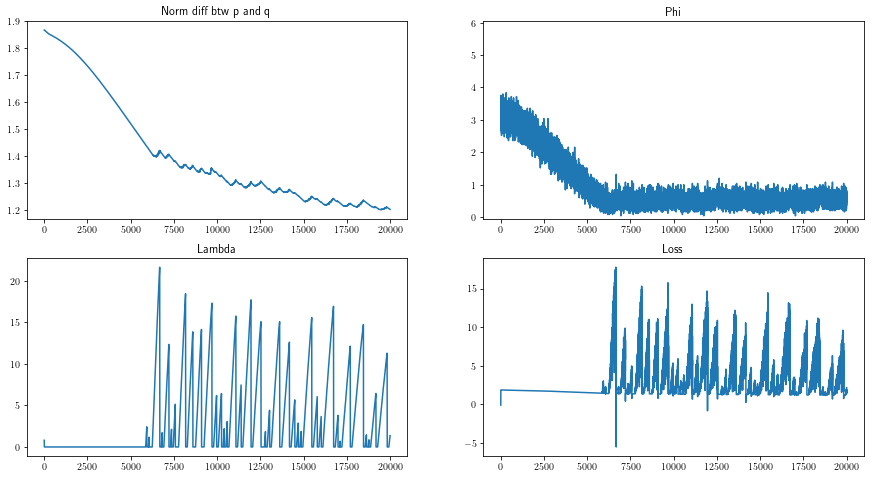

perf_list = [0.03543361728953287] 

 eps_list1 (l1 norm) = [tensor(1.4065, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.7217, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(1.2244, dtype=torch.float64)]  
 alt_eps_list2 (l2 norm) = [tensor(1.2244, dtype=torch.float64)] 


res get paur =[0.03543361728953287], [tensor(1.4065, dtype=torch.float64)]
path get pair = /Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/depth-functions/perf_robustness_profile/unimodal/perf_robustness_dist=maxpair_w=[2.2831823e-01 1.2837668e-04 1.1639423e-09 4.2043390e-11]_delta=1_epochs=20002_dist_type_sym=False_norm_L1_ratio_1.0.pt
PTORCh = tensor([[9.6459e-01, 3.4842e-02, 9.0614e-06, 2.9676e-12, 3.2731e-07, 2.9676e-12,
         5.4236e-04, 1.9591e-05, 2.8648e-12, 5.2753e-22, 1.0348e-13, 5.2753e-22,
         5.0922e-09, 1.6677e-15, 2.8632e-12, 5.2724e-22, 9.3716e-19, 5.2694e-22,
         1.8394e-10, 1.6677e-15, 1.0342e-13, 5.2724e-22, 9.3716e-19, 5.2694e-22]],
    

/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

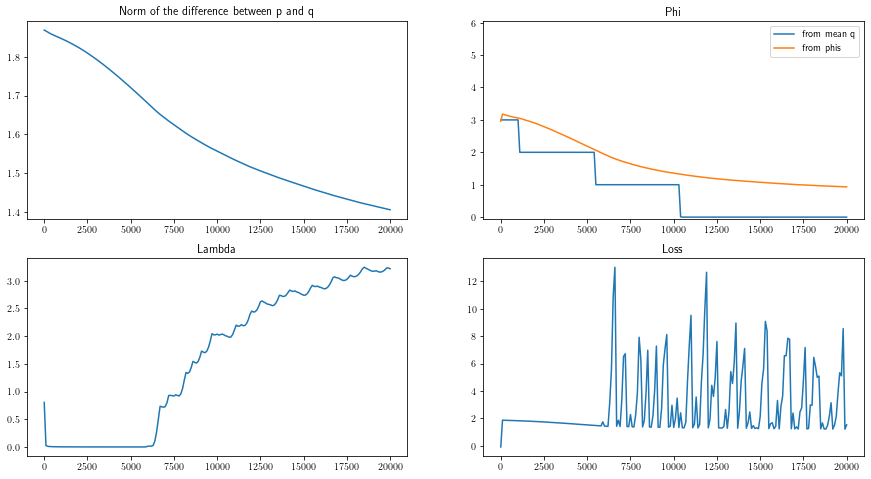

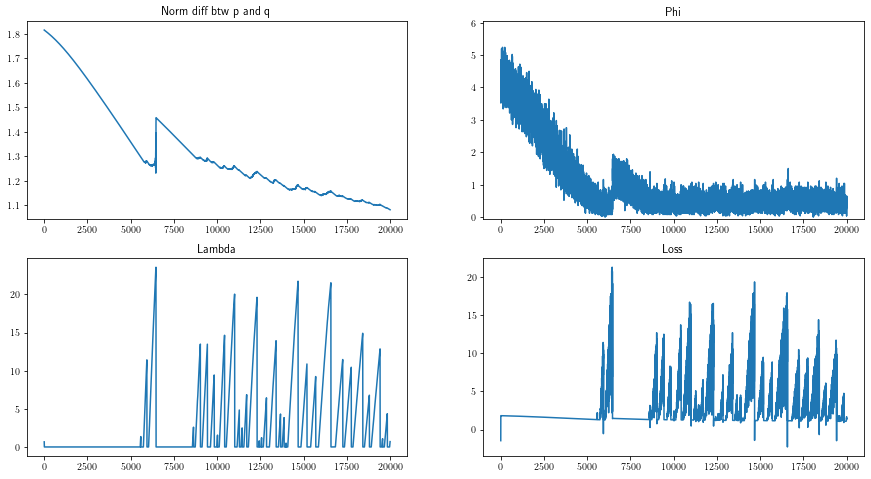

perf_list = [0.03543361728953287] 

 eps_list1 (l1 norm) = [tensor(1.3198, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.6764, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(1.1291, dtype=torch.float64)]  
 alt_eps_list2 (l2 norm) = [tensor(1.1291, dtype=torch.float64)] 


res get paur =[0.03543361728953287], [tensor(1.3198, dtype=torch.float64)]
[0.005905602881588812, 0.005905602881588812] [0.7032653622562615, 0.6599163633434773]


/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  minval = torch.min( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxval = torch.max( torch.tensor(eps_list1[i]), torch.tensor(alt_eps_list1[i]) )
/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_98416/708935748.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

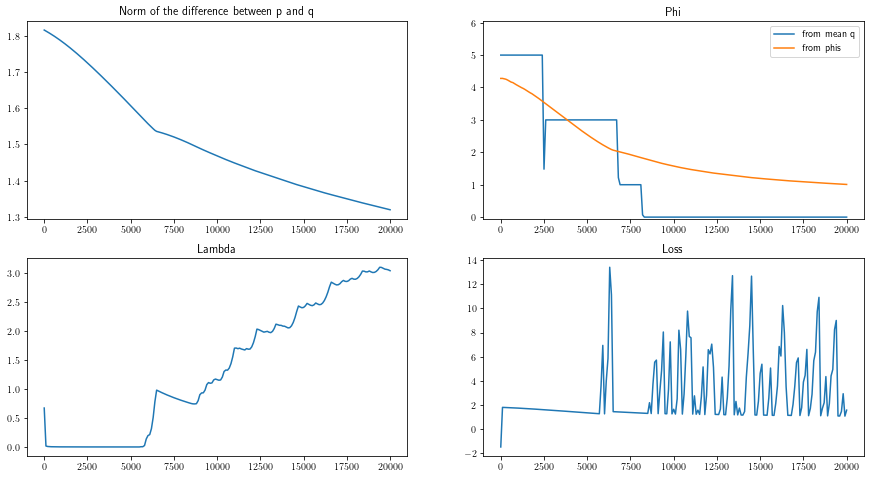

In [150]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 20002
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "unimodal/"
seed_val = 279
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

choose_val = "full"

# Parameters changing for every exp seed = 279
m = 0.01
w = f"[2.2831823e-01 1.2837668e-04 1.1639423e-09 4.2043390e-11]"
title_add = ""

thresholds = np.array([0.05])

# dist
dists = ["erm", "maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]
perf_dirac, tv_dist_dirac = get_pair_results(my_paths, dists, torch_all_ranks, title_add="", plot_training=True, n=4, thresholds=thresholds, choose_val="full")
print(perf_dirac, tv_dist_dirac)



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0)


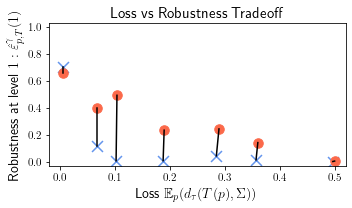

In [157]:
cm = plt.cm.get_cmap('Reds')
myred = cm(1/2)
print(myred)

plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
        })

plt.figure(figsize=(5,3))

median_res_x = [perf_18[0], perf_283[0], perf_1903[0], perf_bucket_001[0], perf_bucket_01[0], perf_uniform[0], perf_dirac[0]]
median_res_y = [tv_dist_18[0], tv_dist_283[0], tv_dist_1903[0], tv_dist_bucket_001[0], tv_dist_bucket_01[0], tv_dist_uniform[0], tv_dist_dirac[0]]

maxpair_res_x = [perf_18[1], perf_283[1], perf_1903[1], perf_bucket_001[1], perf_bucket_01[1], perf_uniform[1], perf_dirac[1]]
maxpair_res_y = [tv_dist_18[1], tv_dist_283[1], tv_dist_1903[1], tv_dist_bucket_001[1], tv_dist_bucket_01[1], tv_dist_uniform[1], tv_dist_dirac[1]]

plt.plot(perf_18, tv_dist_18, "-", c="black")
plt.plot(perf_283, tv_dist_283, "-", c="black")
plt.plot(perf_1903, tv_dist_1903, "-", c="black")
plt.plot(perf_bucket_001, tv_dist_bucket_001, "-", c="black")
plt.plot(perf_bucket_01, tv_dist_bucket_01, "-", c="black")
plt.plot(perf_uniform, tv_dist_uniform, "-", c="black")
plt.plot(perf_dirac, tv_dist_dirac, "-", c="black")

plt.scatter(median_res_x, median_res_y, s=120, c="cornflowerblue", marker="x", label="Kemeny's median")
plt.scatter(maxpair_res_x, maxpair_res_y, s=90, c=myred, marker="o", label=r"Down. Merge ($t=0.05$)")
plt.xlabel(r"Loss $\mathbb{E}_p(d_{\tau}(T(p), \Sigma))$", fontsize=14)
plt.ylabel(r"Robustness at level $1: \hat{\varepsilon}^{\gamma}_{p,T}(1)$", fontsize=14)
plt.title(f"Loss vs Robustness Tradeoff", fontsize=15)
#legend = plt.legend(title="Statistics", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlim((-0.02, 0.52))
plt.ylim((-0.03, 1.03))
#plt.setp(legend.get_title(),fontsize=15)
plt.tight_layout()
plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/for_ppt/tradeoffs.png", dpi=200)
plt.show()

# Plotting

In [ ]:
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

In [ ]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 20000
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "unimodal/"

### Unimodal exps

In [ ]:
# Parameters changing for every exp
w = "[1.1840667 1.1067724 1.0653596 1.0230277]"
title_add = "Loss vs Robustness Tradeoff - Unimodal - Delta=1" #m=0.1 seed 938
prefix = "unimodal/"

# dist
dists = ["erm", "maxpair", "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]
print(my_paths)
thresholds = np.array([0.0096, 0.0102, 0.0170, 0.0198, 0.0265, 0.0366])
#thresholds = np.linspace(0,0.5,11)

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="classic", n=4, thresholds=thresholds)
plt.tight_layout()
plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/classic_unimodal_n=4_seed=938.png", dpi=200)


f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, thresholds=thresholds)

In [ ]:
# Parameters changing for every exp
w = "[158.95894    20.97728     6.6816835   1.9798005]" # seed 938 m=3
title_add = ""
thresholds = np.array([0.2585, 0.2715, 0.3835, 0.4139, 0.4598, 0.4878])
#thresholds = np.linspace(0,0.5,11)
prefix = "unimodal/"

# dist
dists = ["erm", "maxpair", "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="classic", n=4, thresholds=thresholds)
plt.tight_layout()
plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/classic_unimodal_n=4_seed=938_m=3.png", dpi=200)

f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, thresholds=thresholds)


In [ ]:
# Parameters changing for every exp
w = "[0.7752823  0.69426465 0.5638316  0.22069816]" # seed 730 m=1
title_add = ""
thresholds = np.array([0.0277, 0.0519, 0.0791, 0.2188, 0.2589, 0.2785])

# dist
dists = ["erm", "maxpair", "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="classic", n=4, thresholds=thresholds)
plt.tight_layout()
plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/classic_unimodal_n=4_seed=730.png", dpi=200)

f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, thresholds=thresholds)


### Multimodal exps

In [ ]:
# Parameters changing for every exp seed = 37
prefix = "multimodal_sst/"
epochs = 20000
w = "multimodal_sst_m=1.0_seed=37"
title_add = ""
#thresholds = np.array([0.0289, 0.0433, 0.0672, 0.1060, 0.1363, 0.1784])
thresholds = np.array([0.0180, 0.1379, 0.1467, 0.2958, 0.3197, 0.4023])

# dist
dists = ["erm", "maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, thresholds=thresholds)
plt.tight_layout()
plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/classic_multimodal_n=4_seed=37.png", dpi=200)

f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, thresholds=thresholds)


### Pairwise version

#### Unimodal

In [ ]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 50000
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "pairwise_res/unimodal/"

In [ ]:
# Parameters changing for every exp
w = "[0.7752823  0.69426465 0.5638316  0.22069816]" # seed 730 m=1
title_add = ""

# dist
dists = ["erm", "maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

#thresholds = np.linspace(0,0.5,11)
thresholds = np.array([0.0277, 0.0519, 0.0791, 0.2188, 0.2589, 0.2785])

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="pairwise", n=4, thresholds=thresholds)
plt.tight_layout()
plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/pairwise_unimodal_n=4_seed=730.png", dpi=200)

f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, thresholds=thresholds)


In [ ]:
# Parameters changing for every exp
w = "[2.7052357  2.4382606  0.583109   0.26570046]" # seed=37
title_add = "m = 1"

# dist
dists = ["erm", "maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

thresholds = np.linspace(0,0.5,11)

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="pairwise", n=4)
plt.tight_layout()
plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/pairwise_unimodal_n=4_seed=37.png", dpi=200)

f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add)

In [ ]:
# Parameters changing for every exp
w = "[1.1840667 1.1067724 1.0653596 1.0230277]" # seed=938, m=0.1
title_add = ""

# dist
dists = ["erm", "maxpair"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

thresholds = np.array([0.0096, 0.0102, 0.0170, 0.0198, 0.0265, 0.0366])

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="pairwise", n=4, thresholds=thresholds)
plt.tight_layout()
plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/pairwise_unimodal_n=4_seed=938.png", dpi=200)

f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, thresholds=thresholds)

In [ ]:
# Parameters changing for every exp
w = "[158.95894    20.97728     6.6816835   1.9798005]" # seed=938, m=3
title_add = ""

# dist
dists = ["erm", "maxpair"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

thresholds = np.array([0.2585, 0.2715, 0.3835, 0.4139, 0.4598, 0.4878])

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="pairwise", n=4, thresholds=thresholds)
plt.tight_layout()
plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/pairwise_unimodal_n=4_seed=938_m=3.png", dpi=200)

f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, thresholds=thresholds)

### Multimodal

In [ ]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 50000
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "pairwise_res/multimodal_sst/"

In [ ]:
# Parameters changing for every exp seed = 37
w = "multimodal_sst_m=1.0_seed=37"
title_add = ""
#thresholds = np.array([0.0289, 0.0433, 0.0672, 0.1060, 0.1363, 0.1784])
thresholds = np.array([0.0180, 0.1379, 0.1467, 0.2958, 0.3197, 0.4023])

# dist
dists = ["erm", "maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, thresholds=thresholds)
plt.tight_layout()
plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/pairwise_multimodal_n=4_seed=37.png", dpi=200)

f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, thresholds=thresholds)


In [ ]:
# Parameters changing for every exp seed = 29 (m=2)
w = "multimodal_sst_m=2.0_seed=29"
title_add = ""
thresholds = np.array([0.0064, 0.0128, 0.0154, 0.0245, 0.0777, 0.0977, 0.1309, 0.1570, 0.1800, 0.1832, 0.2017, 0.2517, 0.3017, 0.3517])
epochs = 25000

# dist
dists = ["erm", "maxpair"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, thresholds=thresholds)
#plt.tight_layout()
#plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/pairwise_multimodal_n=4_seed=29.png", dpi=200)

f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, thresholds=thresholds)


### Pairwise Unimodal with n=8

In [ ]:
n_items = 8
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

In [ ]:
# Parameters changing for every exp
w = "[4.4905963  2.984672   1.3321997  1.0773835  0.5858078  0.54696006 0.4910444  0.14756523]"
title_add = "m = 1"
epochs = 25000

# dist
dists = ["erm", "maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="pairwise", n=8)
f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add)

In [ ]:
# Parameters changing for every exp
w = "[2.1191027  1.7276204  1.1542095  1.0379709  0.7653808  0.73956746 0.7007456  0.3841422]"
title_add = "m = 0.5"
epochs = 25000

# dist
dists = ["erm","maxpair"]#, "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="pairwise", n=8)
f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add)

In [ ]:
# Parameters changing for every exp seed = 820
w = "[4.4905963  2.984672   1.3321997  1.0773835  0.5858078  0.54696006 0.4910444  0.14756523]"
title_add = "m = 1"
epochs = 75000
prefix = "pairwise_res/unimodal/"
thresholds = np.array([0.0172, 0.0270, 0.0441, 0.0530, 0.1008, 0.1479, 0.1634, 0.1870, 0.1915,
        0.1947, 0.2090, 0.2308, 0.2349, 0.2690, 0.2713, 0.2876, 0.2989, 0.3066,
        0.3360, 0.3452, 0.3588, 0.3796, 0.3847, 0.3915, 0.4004, 0.4015, 0.4530,
        0.4683])

# dist
dists = ["erm", "maxpair"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="pairwise", n=n_items, thresholds=thresholds)
f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, thresholds=thresholds)
                      

In [ ]:
# Parameters changing for every exp seed = 372
w = "[8.780987   4.950233   3.1971316  1.5199904  1.2945006  0.45349538  0.15727499 0.04492239]"
title_add = ""
epochs = 25000
prefix = "pairwise_res/unimodal/"
thresholds = np.array([0.0201, 0.0402, 0.0639, 0.1077, 0.1209, 0.1236, 0.1396, 0.1757, 0.1779,
        0.1784, 0.1817, 0.2093, 0.2119, 0.2230, 0.2332, 0.2356, 0.2385, 0.2407,
        0.2426, 0.2556, 0.2652, 0.2703, 0.2779, 0.2868, 0.2904, 0.2928, 0.2966,
        0.3092, 0.3243, 0.3358, 0.3370, 0.3432, 0.3525, 0.3535, 0.3611, 0.3656,
        0.3716, 0.3759, 0.3811, 0.3914, 0.3918, 0.4063, 0.4100, 0.4162, 0.4175,
        0.4314, 0.4510, 0.4532, 0.4666, 0.4693, 0.4714, 0.4825, 0.4862, 0.4911,
        0.4950])

# dist
dists = ["erm"]#, "maxpair"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=True, type_="pairwise", n=8, thresholds=thresholds)
f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, thresholds=thresholds)
                      

In [ ]:
def return_pairwise_mat(M):
    for i in range(M.shape[0]):
        M[i,i] = torch.tensor(0.0)
        for j in range(i+1, M.shape[0]):
            if M[i,j] > torch.tensor(1.0):
                M[i,j] = torch.tensor(1.0)
            if M[i,j] < torch.tensor(0.0):
                M[i,j] = torch.tensor(0.0)
            M[j,i] = 1.0-M[i,j]
    return M

def monte_carlo_phi(P, Q, dist_Tp_Tq, std_dev_=0.00001, nb_simu=50):
    kernel_conv = lambda _S: MultivariateNormal(_S.reshape(-1), std_dev_*torch.eye(_S.reshape(-1).shape[0])) #MultivariateNormal(_s, std_dev_*torch.eye(_s.size()[-1]))
    rhos = list()
    for i in range(nb_simu):
        Q2 = kernel_conv(Q.float()).sample(torch.Size()).reshape((P.shape[0], P.shape[1]))
        Q2 = return_pairwise_mat(Q2)
        rho = dist_Tp_Tq(P, Q2).detach().numpy().item()
        rhos.append(rho)
    rho_final = np.mean(rhos)
    return torch.tensor(rho_final)

class NewPhi(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    def __init__(self):
        self.name = "New Phi class"

    @staticmethod
    def forward(ctx, input_S, input_backward, P, dist_Tp_Tq, std_dev_, nb_simu):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        with torch.no_grad():
            softsign = torch.nn.Softsign()
            ctx.save_for_backward(input_backward)
            if len(input_S.shape) < 2:
                input_Q2 = torch.zeros((P.shape[0],P.shape[0]))
                input_Q2[torch.triu(torch.ones(P.shape[0], P.shape[0]), 1) == 1] = (softsign(input_S) + 1.0)/2.0
                input_Q2[torch.tril(torch.ones(P.shape[0], P.shape[0]), -1) == 1] = 1.0 - (softsign(input_S) + 1.0)/2.0
            else:
                input_Q2 = input_S
            monte_carlo_val = monte_carlo_phi(P, input_Q2, dist_Tp_Tq, std_dev_=std_dev_, nb_simu=nb_simu)
            return monte_carlo_val

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        back_,  = ctx.saved_tensors
        #print(f"back size = {back_.shape} ({back_}) and grad = {grad_output.shape} ({grad_output})")
        #print(f"size grad phi = {(back_ * grad_output).shape}")
        return (back_ * grad_output), None, None, None, None, None

def subsample_fct(vect, time=10):
    l = len(vect)
    res = vect[0:l:time]
    return res

def plot_end_training_pairwise(P, dist_Tp_Tq, norms_, losses, mean_qs_, phis_, mean_phi2_, lambdas_, mean_lambdas_, grad_data,
                      freq_phi_, norm_type):
    f, ax = plt.subplots(2, 2, figsize=(15, 8))
    ax[0, 0].plot(norms_)
    # ax[0,0].set_ylim([-0.05, 2.05])
    ax[0, 0].set_title(f"Norm diff btw p and q")

    ax[0, 1].plot(phis_)
    ax[0, 1].set_ylim([-0.05, 6.05])
    ax[0, 1].set_title(f"Phi")

    ax[1, 0].plot(lambdas_)
    # ax[1,0].set_ylim([-0.05, 8.05])
    ax[1, 0].set_title(f"Lambda")

    ax[1, 1].plot(losses)
    # ax[1,1].set_ylim([-10.05, 10.05])
    ax[1, 1].set_title(f"Loss")
    plt.show()

    #print("\n \n")
    time_fct = 1000
    x_axis_val = subsample_fct(np.linspace(0, len(mean_lambdas_), len(mean_lambdas_)), time=time_fct)
    f, ax = plt.subplots(2, 2, figsize=(15, 8))

    mean_qs_subsample = subsample_fct(mean_qs_, time_fct)
    mean_qs1_ = [torch.norm(P - torch.tensor(mean_q_), int(norm_type)) for mean_q_ in
                 mean_qs_subsample]  # [mean_q_[0] for mean_q_ in mean_qs_]
    ax[0, 0].plot(x_axis_val, mean_qs1_)
    # ax[0,0].set_ylim([-0.05, 1.05])
    ax[0, 0].set_title(f"Norm of the difference between p and q")

    Phi_ = NewPhi.apply
    mean_phis_ = [Phi_(torch.tensor(mean_q_), grad_data, P, dist_Tp_Tq, 1e-7, 100) for mean_q_ in mean_qs_subsample]
    ax[0, 1].plot(x_axis_val, mean_phis_, label="from mean q")
    ax[0, 1].plot(x_axis_val, subsample_fct(mean_phi2_, time_fct), label="from phis")
    ax[0, 1].legend()
    ax[0, 1].set_ylim([-0.05, 6.05])
    ax[0, 1].set_title(f"Phi")

    ax[1, 0].plot(x_axis_val, subsample_fct(mean_lambdas_, time_fct))
    ax[1, 0].set_title(f"Lambda")

    ax[1, 1].plot(x_axis_val, subsample_fct(losses, time_fct))
    ax[1, 1].set_title(f"Loss")
    plt.plot()

## Revamp

#### Unimodal uniform

[autoreload of app.launcher_classic failed: Traceback (most recent call last):
  File "/Users/m.goibert/miniforge3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/m.goibert/miniforge3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/m.goibert/miniforge3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/m.goibert/miniforge3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/m.goibert/miniforge3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/m.goibert/miniforge3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if up

PTORCh = tensor([[0.0426, 0.0425, 0.0424, 0.0417, 0.0422, 0.0417, 0.0425, 0.0424, 0.0421,
         0.0412, 0.0419, 0.0411, 0.0421, 0.0415, 0.0419, 0.0410, 0.0410, 0.0407,
         0.0419, 0.0414, 0.0417, 0.0409, 0.0410, 0.0407]], dtype=torch.float64)
perf_list = [2.9802862798290857] 

 eps_list1 (l1 norm) = [tensor(0.0022, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.0005, dtype=torch.float64)] 

 alt_eps_list1 (l1 norm) = [tensor(0.0031, dtype=torch.float64)]  
 alt_eps_list2 (l2 norm) = [tensor(0.0031, dtype=torch.float64)] 


normalize l1 norm = [tensor(0.0011, dtype=torch.float64)]
for point nb 0 --> l1_norm = [tensor(0.0011, dtype=torch.float64)]
PTORCh = tensor([[0.0426, 0.0425, 0.0424, 0.0417, 0.0422, 0.0417, 0.0425, 0.0424, 0.0421,
         0.0412, 0.0419, 0.0411, 0.0421, 0.0415, 0.0419, 0.0410, 0.0410, 0.0407,
         0.0419, 0.0414, 0.0417, 0.0409, 0.0410, 0.0407]], dtype=torch.float64)
perf_list = [2.9802862798290857, 2.9802862798290857, 2.9802862798290857, 2.98

PTORCh = tensor([[0.0426, 0.0425, 0.0424, 0.0417, 0.0422, 0.0417, 0.0425, 0.0424, 0.0421,
         0.0412, 0.0419, 0.0411, 0.0421, 0.0415, 0.0419, 0.0410, 0.0410, 0.0407,
         0.0419, 0.0414, 0.0417, 0.0409, 0.0410, 0.0407]], dtype=torch.float64)
perf_list = [2.999838528665991, 2.999838528665991, 2.999838528665991, 2.999838528665991, 2.999827162481257, 2.999827162481257, 2.999827162481257, 2.999827162481257, 2.999827162481257] 

 eps_list1 (l1 norm) = [tensor(0.0037, dtype=torch.float64), tensor(0.0030, dtype=torch.float64), tensor(0.0041, dtype=torch.float64), tensor(0.0028, dtype=torch.float64), tensor(0.0001, dtype=torch.float64), tensor(0.0001, dtype=torch.float64), tensor(6.1150e-05, dtype=torch.float64), tensor(7.1885e-05, dtype=torch.float64), tensor(0.0005, dtype=torch.float64)]  
 eps_list2 (l2 norm) = [tensor(0.0010, dtype=torch.float64), tensor(0.0007, dtype=torch.float64), tensor(0.0012, dtype=torch.float64), tensor(0.0008, dtype=torch.float64), tensor(3.0163e-05, dtype

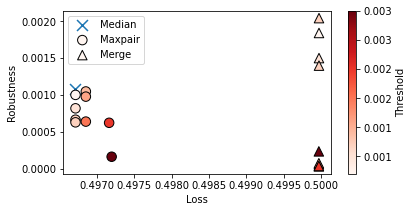

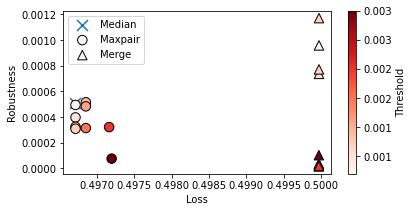

In [81]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 20000
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "unimodal/"
seed_val = 279
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

choose_val = "full"

# Parameters changing for every exp seed = 279
m = 0.01
w = f"[0.99852407 0.9910795  0.9796387  0.97639084]"
title_add = ""

thresholds = np.array([0.0002, 0.0005, 0.0007, 0.0007, 0.0009, 0.0011, 0.0015, 0.0020, 0.0030])

# dist
dists = ["erm", "maxpair", "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="classic", n=n_items, thresholds=thresholds, choose_val=choose_val)
#plt.tight_layout()
#plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/classic_uniform_n=4_seed=279.png", dpi=200)

f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, thresholds=thresholds, choose_val=choose_val)
                      

#### Unimodal peaked

In [ ]:
# Basic (mostly unchanged) parameters
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

delta = 1
epochs = 20000
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "unimodal/"
seed_val = 279
choose_val = "full"

# Parameters changing for every exp seed = 279
m = 10
w = "[2.2831823e-01 1.2837668e-04 1.1639423e-09 4.2043390e-11]"
title_add = ""

thresholds = np.array([0.1163, 0.2121, 0.2326, 0.3079, 0.3489, 0.4037, 0.4652, 0.4995])

# dist
dists = ["erm", "maxpair", "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="classic", n=n_items, thresholds=thresholds, choose_val=choose_val)
#plt.tight_layout()
#plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/classic_dirac_n=4_seed=279.png", dpi=200)


f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, thresholds=thresholds)
  

#### Two untied classic

In [ ]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 50000
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "two_untied/"
seed_val = 279
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

choose_val = "alt"

# Parameters changing for every exp seed = 279
mixture_val = 1.0
gap_mode = 0.1
w = f"two_untied_mix={mixture_val}_gap={gap_mode}_seed={seed_val}_n=4"
title_add = ""

thresholds = np.array([0.0250, 0.0501, 0.0751, 0.1001, 0.1438, 0.2626, 0.3813])

# dist
dists = ["erm", "maxpair", "merge"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="classic", n=n_items, thresholds=thresholds, choose_val=choose_val)
#plt.tight_layout()
#plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/classic_two_untied_n=4_seed=279.png", dpi=200)

f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, thresholds=thresholds, choose_val=choose_val)
                      

#### Two Untied Pairwise

In [ ]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 50000
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "pairwise_res/two_untied/"
seed_val = 279
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

choose_val = "full"

# Parameters changing for every exp seed = 279
mixture_val = 1
gap_mode = 0.1
w = f"two_untied_mix={mixture_val}_gap={gap_mode}_seed={seed_val}_n=4"
title_add = ""

thresholds = np.array([0.0250, 0.0501, 0.0751, 0.1001, 0.1438, 0.2626, 0.3813])

# dist
dists = ["erm", "maxpair"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="pairwise", n=n_items, thresholds=thresholds, choose_val=choose_val)
plt.tight_layout()
plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/pairwise_two_untied_n=4_seed=279.png", dpi=200)

f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, plot_training=False, type_="pairwise", n=n_items, thresholds=thresholds, choose_val=choose_val)
                      

In [ ]:
# Basic (mostly unchanged) parameters
delta = 1
epochs = 50000
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "pairwise_res/two_untied/"
seed_val = 279
n_items = 8
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

choose_val="alt"

# Parameters changing for every exp seed = 279
mixture_val = 1
gap_mode = 0.01
w = f"two_untied_mix={mixture_val}_gap={gap_mode}_seed={seed_val}_n=8"
title_add = ""

thresholds = np.array([0.0009, 0.0015, 0.0017, 0.0021, 0.0026, 0.0028, 0.0034, 0.0051])

# dist
dists = ["erm", "maxpair"] #, merge]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="pairwise", n=n_items, thresholds=thresholds, choose_val=choose_val)
plt.tight_layout()
plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/pairwise_two_untied_n=8_seed=279.png", dpi=200)

f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, plot_training=False, type_="pairwise", n=n_items, thresholds=thresholds, choose_val=choose_val)
                      

In [ ]:
# Basic (mostly unchanged) parameters
delta = 3
epochs = 50000
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
prefix = "pairwise_res/two_untied/"
seed_val = 279
n_items = 8
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

choose_val = "alt"

# Parameters changing for every exp seed = 279
mixture_val = 1
gap_mode = 0.01
w = f"two_untied_mix={mixture_val}_gap={gap_mode}_seed={seed_val}_n=8"
title_add = ""

#thresholds = np.array([0.0017, 0.0026, 0.0034, 0.0043, 0.0051, 0.1270, 0.2513, 0.3757])
thresholds = np.array([0.0017, 0.0026, 0.0034, 0.0043, 0.0051])#, 0.1270, 0.2513, 0.3757])

# dist
dists = ["erm", "maxpair"]
my_paths = [get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, prefix=prefix) for dist in dists]

f1 = exp_plot(my_paths, dists, torch_all_ranks, norm="L1", title_add=title_add, plot_training=False, type_="pairwise", n=n_items, thresholds=thresholds, choose_val=choose_val)
plt.tight_layout()
plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/pairwise_two_untied_n=8_delta=3_seed=279.png", dpi=200)

f2 = exp_plot(my_paths, dists, torch_all_ranks, norm="L2", title_add=title_add, plot_training=False, type_="pairwise", n=n_items, thresholds=thresholds, choose_val=choose_val)
                      

In [ ]:
# Exp to launch afterward
# Seeds unimodal = 938, 37
# Seeds multimodal = 453

#python app/launcher_classic.py --exp_types "multimodal_sst" --epochs_list "20000" --seed_vals "453" --ms "0.1;0.5;1;3"
# DONE



# Pairwise
# Done except merge
#python app/launcher_pairwise.py --exp_types "unimodal" --epochs_list "50000" --seed_vals "938" --ms "0.1;0.5;1;3"

# More items
#DONE -- python app/launcher_pairwise.py --exp_types "unimodal" --epochs_list "25000" --seed_vals "820" --ms "0.5;1;3" --n 8
# python app/launcher_pairwise.py --exp_types "unimodal" --epochs_list "50000" --seed_vals "429" --ms "1" --n 8


###

#python app/launcher_classic.py --exp_types "multimodal_sst" --epochs_list "20000" --seed_vals "453" --ms "63"





In [ ]:
# Nice plots
# Classic, n=4, epochs=20000, seed=938, m=0.01 or m=3
# Pairwise, n=4
# Pairwise, n=8

In [ ]:
torch.manual_seed(938)

logits = torch.sort(torch.randn(4), descending=True)[0].numpy()
w = np.exp(logits)
w